In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
from astropy import units as u
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense 


c:\Users\weron\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def cosine_distance_loss(y_true, y_pred):

    y_true_norm = tf.nn.l2_normalize(y_true, axis=1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=1)

    # Iloczyn skalarny (Cosine Similarity)
    # Wynik jest od -1 (przeciwne) do 1 (zgodne)
    cosine_similarity = tf.reduce_sum(y_true_norm * y_pred_norm, axis=1)

    # Chcemy minimalizowac strate
    # Kąt 0 st -> cos = 1. Chcemy żeby loss był 0.
    # Loss = 1 - cos
    return 1 - cosine_similarity

In [3]:
df = pd.read_hdf("atm_neutrino_classA.h5", "y")

print("Attributes:")
print(df.columns)
print("Exemplary data: ")
print(df.head())

Attributes:
Index(['jmuon_E', 'jmuon_t', 'jmuon_likelihood', 'jmuon_JENERGY_ENERGY',
       'jmuon_JENERGY_CHI2', 'jmuon_JENERGY_NDF', 'jmuon_pos_x', 'jmuon_pos_y',
       'jmuon_pos_z', 'jmuon_dir_x', 'jmuon_dir_y', 'jmuon_dir_z',
       'jmuon_JGANDALF_BETA0_RAD', 'jmuon_JGANDALF_BETA1_RAD',
       'jmuon_JGANDALF_CHI2', 'jmuon_JGANDALF_NUMBER_OF_HITS',
       'jmuon_JSHOWERFIT_ENERGY', 'jmuon_AASHOWERFIT_ENERGY', 'energy',
       'dir_x', 'dir_y', 'dir_z'],
      dtype='object')
Exemplary data: 
     jmuon_E       jmuon_t  jmuon_likelihood  jmuon_JENERGY_ENERGY  \
0   7.440156  7.473714e+07         56.391503              7.440156   
1   3.180105  8.278715e+07        109.102307              3.180104   
2   0.254257  3.343280e+07         47.650844              0.254257   
3  11.560810  3.338544e+07        240.448806             11.560810   
4   0.000321  7.333352e+06         82.560595              0.000321   

   jmuon_JENERGY_CHI2  jmuon_JENERGY_NDF  jmuon_pos_x  jmuon_pos_y  \
0    

In [4]:
# define input and target columns
input_dir_cols = ['jmuon_dir_x', 'jmuon_dir_y', 'jmuon_dir_z', 'jmuon_likelihood']
target_dir_cols = ['dir_x', 'dir_y', 'dir_z']
# maybe use the polar coordinates, to reduce the dimentionality?


In [5]:
# 1. Create a Cartesian Representation object from your columns
# We multiply by u.one to treat them as dimensionless quantities
cart_coords = CartesianRepresentation(
    x=df['dir_x'].values * u.one, 
    y=df['dir_y'].values * u.one, 
    z=df['dir_z'].values * u.one
)

# 2. Convert to Spherical Coordinates
sph_coords = cart_coords.represent_as(SphericalRepresentation)

# 3. Extract columns
# Note: Astropy gives 'Latitude' (-90 to +90). 
# If you want 'Zenith' (0 to 180), you calculate "Co-latitude" (90 - Lat).

df['azimuth'] = sph_coords.lon.rad           # Azimuth in Radians (-pi to pi equivalent)
df['zenith']  = (90*u.deg - sph_coords.lat).rad  # Zenith in Radians (0 to pi)

# Optional: Verify magnitude is 1 (since they are direction vectors)
# df['r'] = sph_coords.distance 

print(df[['dir_x', 'dir_y', 'dir_z', 'azimuth', 'zenith']].head())

# Force azimuth to be between -180 and +180 degrees (or -pi to +pi radians)
df['azimuth'] = sph_coords.lon.wrap_at(180 * u.deg).rad

      dir_x     dir_y     dir_z   azimuth    zenith
0 -0.042679 -0.234725 -0.971124  4.532530  2.900696
1  0.147280  0.881432 -0.448760  1.405234  2.036174
2 -0.778127  0.333997  0.531945  2.736143  1.009901
3  0.367896  0.158540  0.916252  0.406889  0.412174
4  0.658978 -0.749978  0.057283  5.433290  1.513482


In [6]:
target_dir_cols = ['dir_x', 'dir_y', 'dir_z']
target_dir_cols = ['zenith', 'azimuth']
# maybe use the polar coordinates, to reduce the dimentionality?

In [7]:
# convert it into the matrix data
X_dir = df[input_dir_cols].values
y_dir = df[target_dir_cols].values

In [8]:
X_dir_train, X_dir_test, y_dir_train, y_dir_test = train_test_split(X_dir, y_dir, train_size= 0.8, test_size= 0.2, random_state= 42)


In [9]:
#direction scaler
scaler_dir = StandardScaler()
X_dir_train_scaled = scaler_dir.fit_transform(X_dir_train)
X_dir_test_scaled = scaler_dir.fit_transform(X_dir_test)

print("Basic stats for X_en_train after scaling: ")
print(f"Mean: {np.mean(X_dir_train_scaled[:,0]):.2f}, Std: {np.std(X_dir_train_scaled[:,0]):.2f}")


Basic stats for X_en_train after scaling: 
Mean: 0.00, Std: 1.00


In [10]:
X_dir_train_cnn = X_dir_train_scaled.reshape(X_dir_train_scaled.shape[0], X_dir_train_scaled.shape[1], 1)
X_dir_test_cnn = X_dir_test_scaled.reshape(X_dir_test_scaled.shape[0], X_dir_test_scaled.shape[1], 1)

print("Shape before reshaping: ", X_dir_train_cnn.shape)

Shape before reshaping:  (6454, 4, 1)


In [11]:
model = Sequential()

# input_shape=(4, 1) - 4 kroki, 1 kanał (po reshape) 
model.add(Input(shape=(4, 1))) 

# Conv1D: szuka wzorców. 32 filtry, okno wielkości 2. 
model.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 

model.add(Flatten())

model.add(Dense(64, activation='relu'))

# 3 neurony (dir_x, dir_y, dir_z), output -> regression
model.add(Dense(2, activation='linear'))

# optimizers and loss function
model.compile(optimizer='adam', loss=cosine_distance_loss, metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,434 (25.13 KB)

 Trainable params: 6,434 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# training
history = model.fit(x = X_dir_train_cnn, 
                    y = y_dir_train,
                    epochs = 20,
                    batch_size = 64,
                    validation_split = 0.2,
                    verbose = 1)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2469 - mae: 1.1477 - val_loss: 0.1865 - val_mae: 1.0899
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1869 - mae: 1.0851 - val_loss: 0.1824 - val_mae: 1.0805
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1847 - mae: 1.0705 - val_loss: 0.1826 - val_mae: 1.0668
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1842 - mae: 1.0553 - val_loss: 0.1806 - val_mae: 1.0434
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1839 - mae: 1.0413 - val_loss: 0.1808 - val_mae: 1.0303
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1831 - mae: 1.0261 - val_loss: 0.1822 - val_mae: 1.0217
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1830 - mae: 1.0228 - val_loss: 0.1800 - val_mae: 1.0171
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1827 - mae: 1.0115 - val_loss: 0.1813 - val_mae: 1.0032
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1832 - mae:

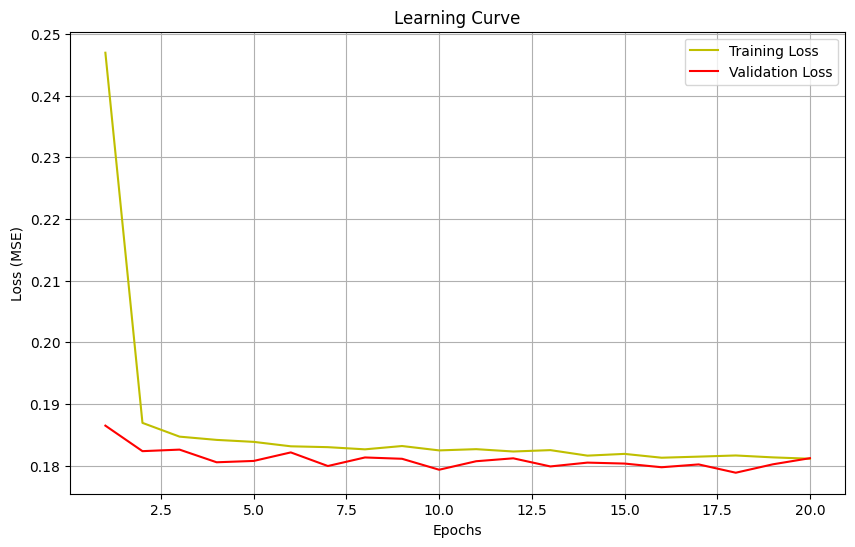

<Figure size 640x480 with 0 Axes>

In [13]:
# metrics, validation check
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss, 'y', label='Training Loss') 
plt.plot(epochs_range, val_loss, 'r', label='Validation Loss') 
plt.title('Learning Curve') 
plt.xlabel('Epochs') 
plt.ylabel('Loss (MSE)') 
plt.legend() 
plt.grid(True) 
plt.show() 
plt.savefig("loss_curve.png")

In [21]:
def train_and_evaluate(file_name, class_label):
    print(f"\n{'='*40}")
    print(f" EVALUATING CLASS: {class_label} ({file_name})")
    print(f"{'='*40}")

    # reading the data from the file
    try:
        df = pd.read_hdf(file_name, key = 'y')
    except FileNotFoundError:
        return None
    
    initial_len = len(df)
    df = df.dropna()
    final_len = len(df)

    if final_len < initial_len:
        print(f"Removed: {initial_len - final_len}")

    if final_len == 0:
        return None
    
    # define input and target columns
    input_dir_cols = ['jmuon_dir_x', 'jmuon_dir_y', 'jmuon_dir_z', 'jmuon_likelihood']

    # new part - reducing dimentionality
    # 1. Create a Cartesian Representation object from your columns
    # We multiply by u.one to treat them as dimensionless quantities
    cart_coords = CartesianRepresentation(
        x=df['dir_x'].values * u.one, 
        y=df['dir_y'].values * u.one, 
        z=df['dir_z'].values * u.one
    )

    # 2. Convert to Spherical Coordinates
    sph_coords = cart_coords.represent_as(SphericalRepresentation)

    # 3. Extract columns
    # Note: Astropy gives 'Latitude' (-90 to +90). 
    # If you want 'Zenith' (0 to 180), you calculate "Co-latitude" (90 - Lat).

    df['azimuth'] = sph_coords.lon.rad           # Azimuth in Radians (-pi to pi equivalent)
    df['zenith']  = (90*u.deg - sph_coords.lat).rad  # Zenith in Radians (0 to pi)

    # Optional: Verify magnitude is 1 (since they are direction vectors)
    # df['r'] = sph_coords.distance 

    print(df[['dir_x', 'dir_y', 'dir_z', 'azimuth', 'zenith']].head())

    # Force azimuth to be between -180 and +180 degrees (or -pi to +pi radians)
    df['azimuth'] = sph_coords.lon.wrap_at(180 * u.deg).rad


    target_dir_cols = ['zenith', 'azimuth']

    X_dir = df[input_dir_cols].values
    y_dir = df[target_dir_cols].values

    X_train, X_test, y_train, y_test = train_test_split(
        X_dir, y_dir, test_size=0.2, random_state=42
    )    

    scaler_dir = StandardScaler()
    X_dir_train_scaled = scaler_dir.fit_transform(X_train)
    X_dir_test_scaled = scaler_dir.transform(X_test)

    X_dir_train_cnn = X_dir_train_scaled.reshape(X_dir_train_scaled.shape[0], 4, 1)
    X_dir_test_cnn = X_dir_test_scaled.reshape(X_dir_test_scaled.shape[0], 4, 1)

    model = Sequential()

    # input_shape=(4, 1) - 4 kroki, 1 kanał (po reshape) 
    model.add(Input(shape=(4, 1))) 

    # Conv1D: szuka wzorców. 32 filtry, okno wielkości 2. 
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))

    # 3 neurony (dir_x, dir_y, dir_z), output -> regression
    model.add(Dense(2, activation='linear'))

    # optimizers and loss function
    model.compile(optimizer='adam', loss=cosine_distance_loss, metrics=['mae'])

    # training
    history = model.fit(x = X_dir_train_cnn, 
                    y = y_train,
                    epochs = 20,
                    batch_size = 64,
                    validation_split = 0.2,
                    verbose = 1)
    
    # evaluation
    y_pred = model.predict(X_dir_test_cnn, verbose=0)

    # calculating angle, preveting so it won't be zero
    def get_angle(v1, v2):
        
        epsilon = 1e-8
        norm_v1 = np.linalg.norm(v1, axis=1, keepdims=True) + epsilon
        norm_v2 = np.linalg.norm(v2, axis=1, keepdims=True) + epsilon

        v1_n = v1 / norm_v1
        v2_n = v2 / norm_v2

        dot = np.sum(v1_n * v2_n, axis=1)
        dot = np.clip(dot, -1.0, 1.0)
        return np.degrees(np.arccos(dot))

    angles = get_angle(y_test, y_pred)

    angles = angles[~np.isnan(angles)]

    if len(angles) == 0:
        median_error = np.nan
    else:
        median_error = np.median(angles)

    print(f"Angle error median: {median_error:.2f} stopni")
    return median_error, history


In [22]:
files_map = {
    'Class A (Anti-Elec CC)': 'atm_neutrino_classA.h5',
    'Class B (Anti-Muon CC)': 'atm_neutrino_classB.h5',
    'Class C (Anti-Muon NC)': 'atm_neutrino_classC.h5',
    'Class D (Anti-Tau CC)':  'atm_neutrino_classD.h5',
    'Class E (Elec CC)':      'atm_neutrino_classE.h5',
    'Class F (Muon CC)':      'atm_neutrino_classF.h5',
    'Class G (Muon NC)':      'atm_neutrino_classG.h5',
    'Class H (Tau CC)':       'atm_neutrino_classH.h5',
}

results = {}
histories = {} ##robimy slownik do przechownaia historii uczenia

for label, filename in files_map.items():
    result_tuple = train_and_evaluate(filename, label)
    if result_tuple is not None:
        metric, hist = result_tuple
        results[label] = metric
        histories[label] = hist


 EVALUATING CLASS: Class A (Anti-Elec CC) (atm_neutrino_classA.h5)
      dir_x     dir_y     dir_z   azimuth    zenith
0 -0.042679 -0.234725 -0.971124  4.532530  2.900696
1  0.147280  0.881432 -0.448760  1.405234  2.036174
2 -0.778127  0.333997  0.531945  2.736143  1.009901
3  0.367896  0.158540  0.916252  0.406889  0.412174
4  0.658978 -0.749978  0.057283  5.433290  1.513482
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2316 - mae: 1.1965 - val_loss: 0.1879 - val_mae: 1.1379
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1921 - mae: 1.1038 - val_loss: 0.1858 - val_mae: 1.0806
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1858 - mae: 1.0797 - val_loss: 0.1817 - val_mae: 1.0785
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1845 - mae: 1.0646 - val_loss: 0.1805 - val_mae: 1.0519
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1840 - mae: 1.0397 - val_loss: 0.1805 - val_mae: 1.0417
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s

Class A (Anti-Elec CC): 14.11°
Class B (Anti-Muon CC): 6.71°
Class C (Anti-Muon NC): 17.79°
Class D (Anti-Tau CC): 10.20°
Class E (Elec CC): 15.48°
Class F (Muon CC): 8.37°
Class G (Muon NC): 15.17°
Class H (Tau CC): 10.94°


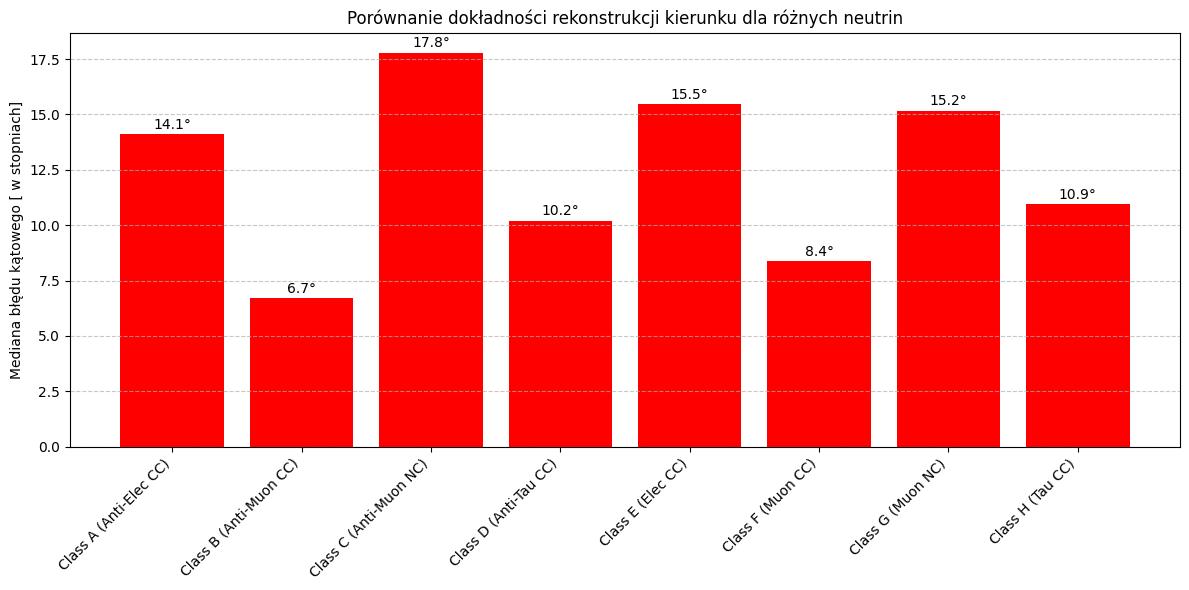

In [ ]:
if results:
    for cls, err in results.items():
        print(f"{cls}: {err:.2f}°")

    plt.figure(figsize=(12, 6))
    names = list(results.keys())
    values = list(results.values())

    bars = plt.bar(names, values, color='red')

    plt.ylabel('Angle error median [degrees]')
    plt.title('Comparison of accuracy of track reconstruction for different neutrino')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Dodanie liczb nad słupkami
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.1f}°', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("Err2")

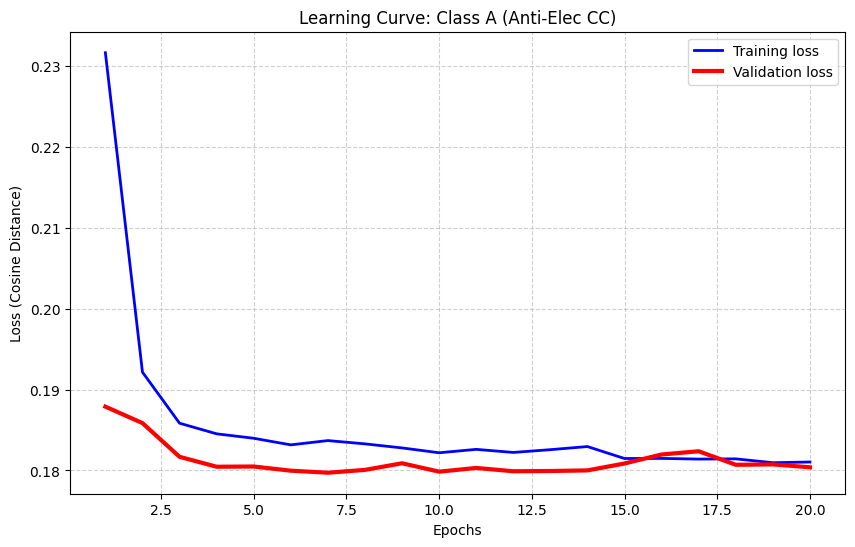

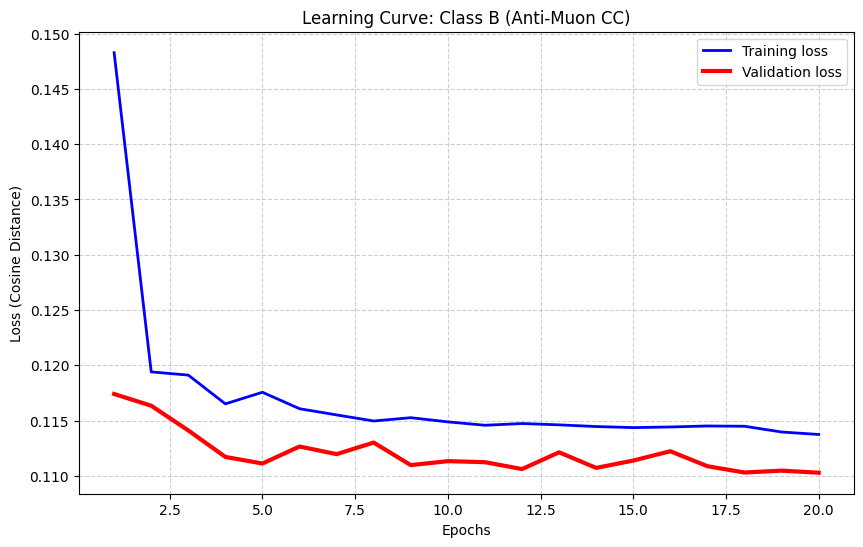

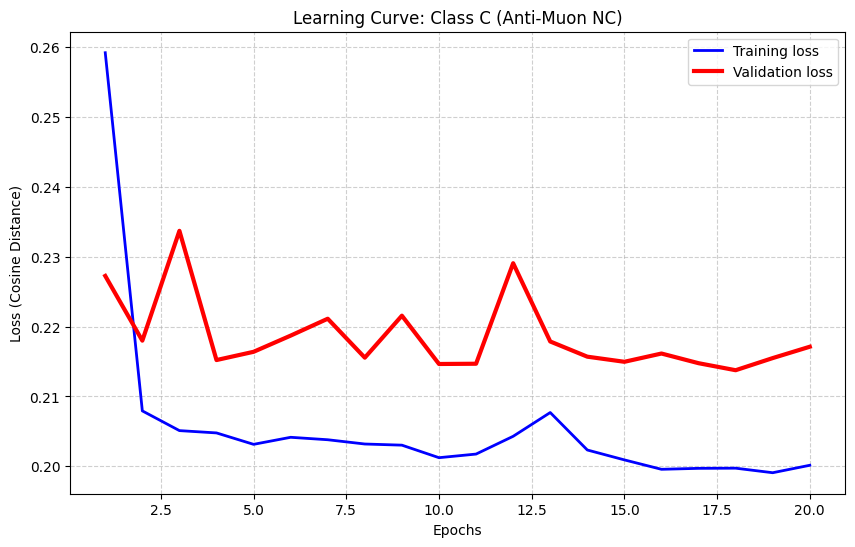

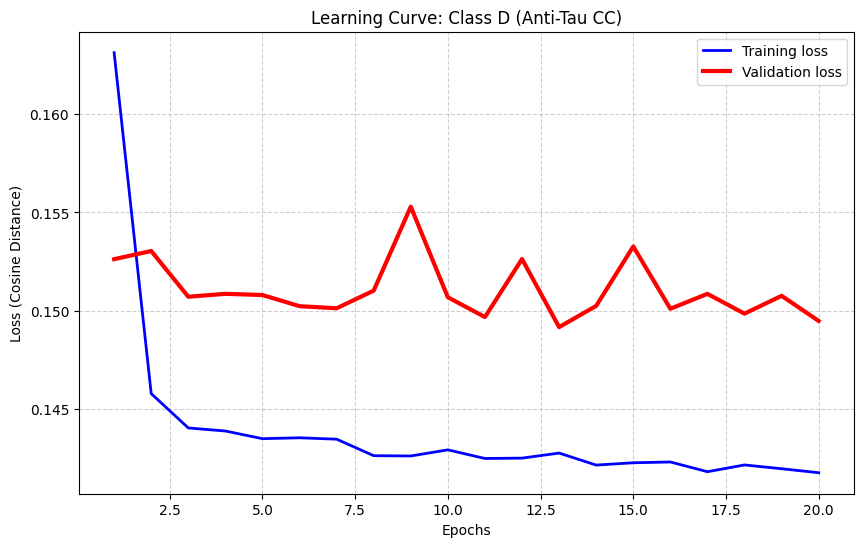

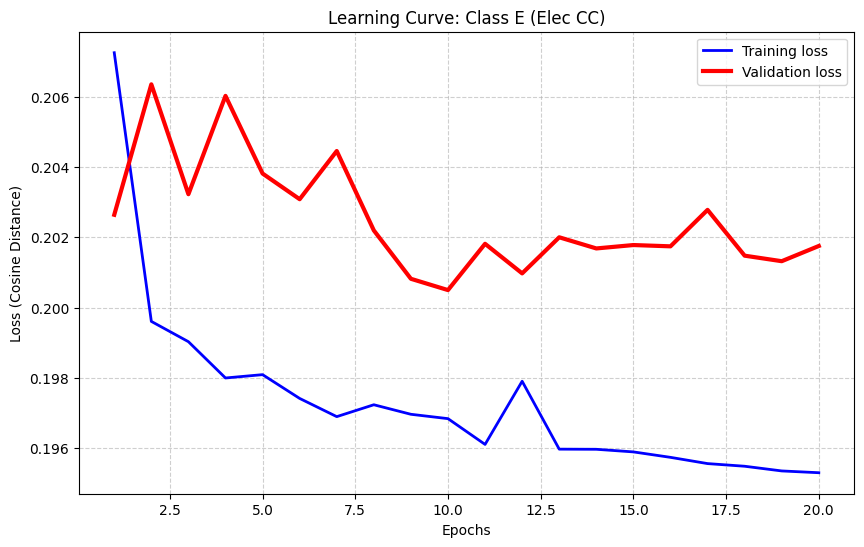

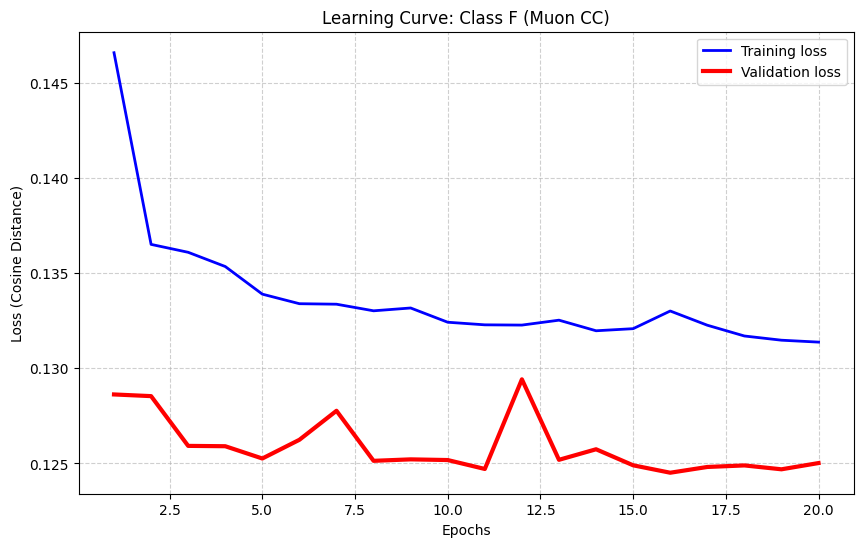

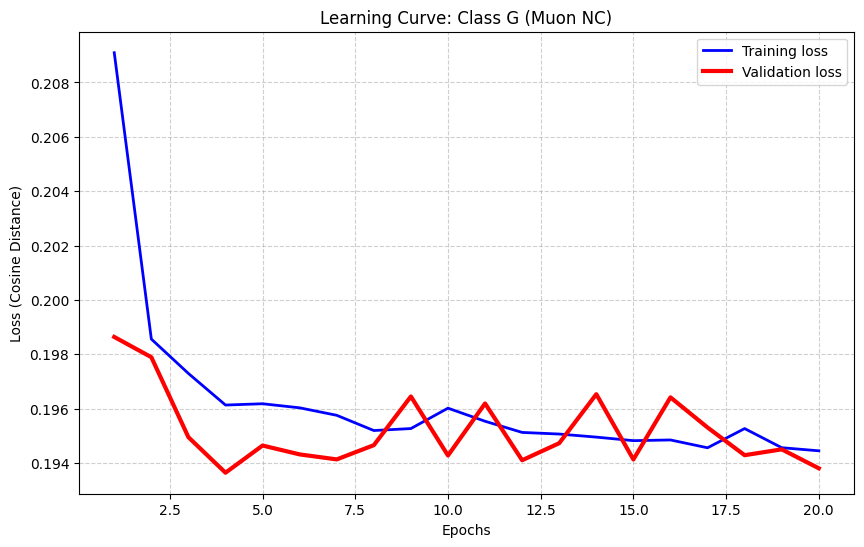

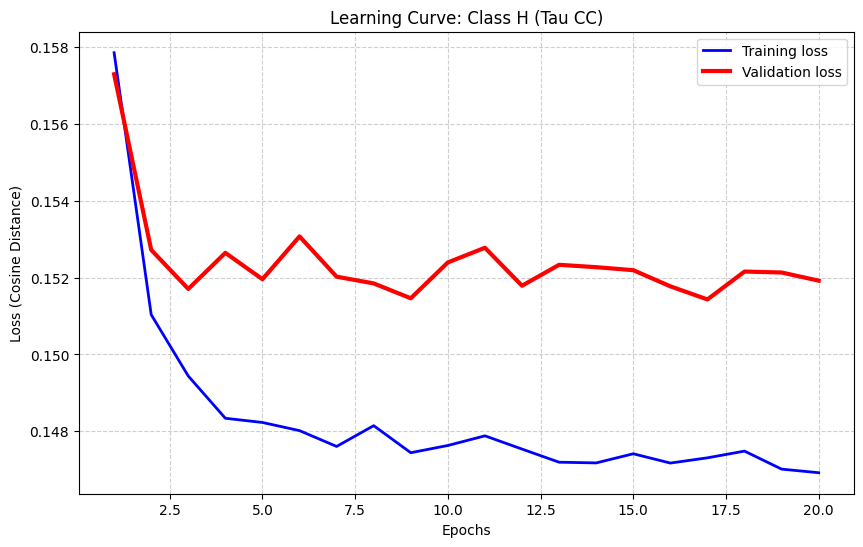

In [24]:
if histories:
    # Pętla po wszystkich zapisanych historiach
    for class_label, history_obj in histories.items():


        loss = history_obj.history['loss']
        val_loss = history_obj.history['val_loss']
        epochs_range = range(1, len(loss) + 1)


        plt.figure(figsize=(10, 6))
        plt.plot(epochs_range, loss, 'b-', linewidth=2, label='Training loss')
        plt.plot(epochs_range, val_loss, 'r-', linewidth=3, label='Validation loss')


        plt.title(f'Learning Curve: {class_label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Cosine Distance)')
        plt.legend(loc='upper right')
        plt.grid(True, which='both', linestyle='--', alpha=0.6)


        plt.show()

else:
    sys.exit(1)